# Pre-Processing & Model First Pass

Within this section I'll preprocess and model my data.

Before I model the data we finalized in the last section, I'll need to make sure all of the data are ready to be modeled. I'll preprocess the data which includes onehotencoding my categorical features, scale any continuous features, and remove unencessary features to create a model ready dataframe.

### Library Imports 

In [45]:
import numpy as np
import requests
import pickle
import time
import seaborn as sns

import pandas as pd
from pandas import json_normalize

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pycaret
from pycaret.regression import *
from pycaret.regression import RegressionExperiment

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

from scipy.stats import zscore

### Data Imports

In [46]:
with open('pickles/df.pkl', 'rb') as f:
    df = pickle.load(f)

### Creating Model df

Since many of the features in our df are not necessary, or useful, in the modelling process, I'll create a new dataframe that contains all of the features I'm interested as using within the model.

In [47]:
df.head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
0,HK,Hong Kong,2000,2005,0.0,1.3,0.00,0.000,1.3,0.000,...,202.6,2003,6,40,0,1,4,8,21.69928571,0.769231
1,HK,Hong Kong,2001,2005,0.0,3.5,0.25,0.875,0.0,2.625,...,202.6,2003,6,40,0,1,4,8,21.69928571,0.571429
2,HK,Hong Kong,1986,1989,0.0,4.6,1.00,4.600,0.0,0.000,...,202.6,1988,1,13,1,1,6,4,21.69928571,0.217391
3,HK,Hong Kong,1997,2001,0.0,2.1,1.00,2.100,0.0,0.000,...,202.6,1999,1,13,1,1,4,5,21.69928571,0.000000
4,HK,Hong Kong,2005,2009,0.0,1.8,1.00,1.800,0.0,0.000,...,202.6,2007,15,96,0,1,3,19,21.69928571,0.555556


In [48]:
drop_cols = ['country','city','start_year','end_year','cost','currency','cost_km','cost_real','cost_km_2023','time_diff','lat','lng','wrb_class_name']
df_model = df.drop(columns =drop_cols)

In [49]:
def convert_str_to_float(val):
    if isinstance(val, str):
        return float(val.replace(',', ''))
    return val

cols_to_exclude = ['region', 'sub_region','train_type']
df_model.loc[:, ~df_model.columns.isin(cols_to_exclude)] = df_model.loc[:, ~df_model.columns.isin(cols_to_exclude)].applymap(convert_str_to_float)

In [50]:
print(df_model['train_type'].unique())


['MRT' 'Light Rail' 'Tram' 'Regional Rail' 'Monorail' 'Streetcar' 'APM']


### Data Type Subsets

Our data contains several types of data: continuous, binary, ordinal, and categorical. I'd like to create lists of this data types before proceeding.

In [55]:
cont_feats = df_model.drop(columns=['region', 'sub_region','wrb_class_value','cost_real_2023','train_type']).columns.tolist()
cat_feats = ['region', 'sub_region', 'train_type', 'wrb_class_value']

As noted above, there are several binary features in this dataset. I'll include these features within the continuous features as the downside for scaling a binary feature would simply be a loss of interpretability. 

### PyCaret Setup

#### Modelling with Pycaret

In [56]:
print('cost_real_2023' in df_model.columns)

True


In [57]:
data = df_model.sample(frac=0.85, random_state=786)
data_unseen = df_model.drop(data.index)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (1414, 73)
Unseen Data For Predictions: (250, 73)


In [58]:
s = setup(data,
          target='cost_real_2023',
          categorical_features=cat_feats,
          numeric_features=cont_feats,
          normalize=True,
          normalize_method='zscore',
          verbose=False
         )

In [59]:
best = compare_models(exclude = ['lar','lr'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,2744.6999,149193058.8000,9004.6479,0.0916,1.2029,21.3912,0.1190
lightgbm,Light Gradient Boosting Machine,2710.3573,143901932.3970,8955.1461,0.0563,1.2651,24.7327,0.5430
dummy,Dummy Regressor,3847.5274,149987855.6000,9252.8681,-0.0292,1.8550,22.2201,0.1260
rf,Random Forest Regressor,2513.7942,205003203.6376,10844.2482,-0.7338,1.0270,17.8442,0.3130
catboost,CatBoost Regressor,2430.1386,214504222.8320,10702.1681,-0.7909,1.0466,16.2913,0.5910
par,Passive Aggressive Regressor,2219.1904,162007520.1004,9424.7973,-1.0773,1.0729,4.1670,0.1190
gbr,Gradient Boosting Regressor,2719.2978,254245370.2926,12034.1376,-1.4648,1.1121,17.2265,0.1760
huber,Huber Regressor,2245.1738,168244694.9050,9581.6458,-1.4755,1.0452,3.5153,0.1190
ada,AdaBoost Regressor,5628.0376,249396599.0696,11905.0540,-1.4803,2.1198,35.7577,0.1420
et,Extra Trees Regressor,2506.2626,263496373.9777,12097.5088,-1.6185,0.9732,24.2257,0.2350


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

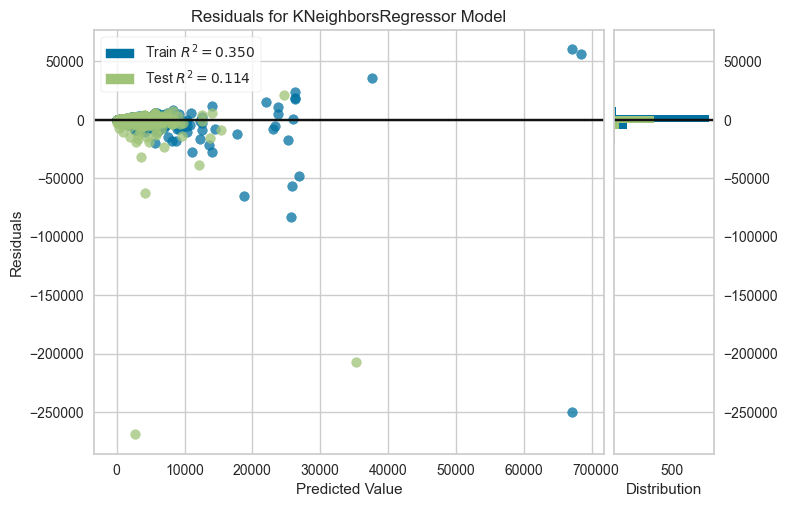

In [60]:
plot_model(best, plot = 'residuals')

In [61]:
plot_model(best, plot = 'residuals_interactive')

    'data': [{'hovertemplate': 'Split=train<br>Predictions…

### Model Refinement

The above model represents a first pass at modelling the data. This iteration revealed several ways to improve the results of my model, which I will outline below.

In [62]:
predictions = predict_model(best, data=data_unseen)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,9985.5498,17429776384.0000,132021.8750,-0.0040,1.2496,6.4486


In [63]:
finalized_best = finalize_model(best)

#### Generating a table of Residuals

In [64]:
predictions = predict_model(finalized_best, data=data_unseen)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,9908.2305,17361864704.0000,131764.4219,-0.0001,1.1063,2.6418


In [66]:
predictions['Residuals'] = predictions['cost_real_2023'] - predictions['prediction_label']
mean_res = np.mean(predictions['Residuals'])
std_res = np.std(predictions['Residuals'])
predictions['standardized_residuals'] = (predictions['Residuals'] - mean_res) / std_res

In [67]:
outliers = predictions.sort_values(by='standardized_residuals', key=abs, ascending=False)

In [68]:
outliers_list = outliers[abs(outliers['standardized_residuals'])>1].index.tolist()

In [69]:
len(outliers_list)

1

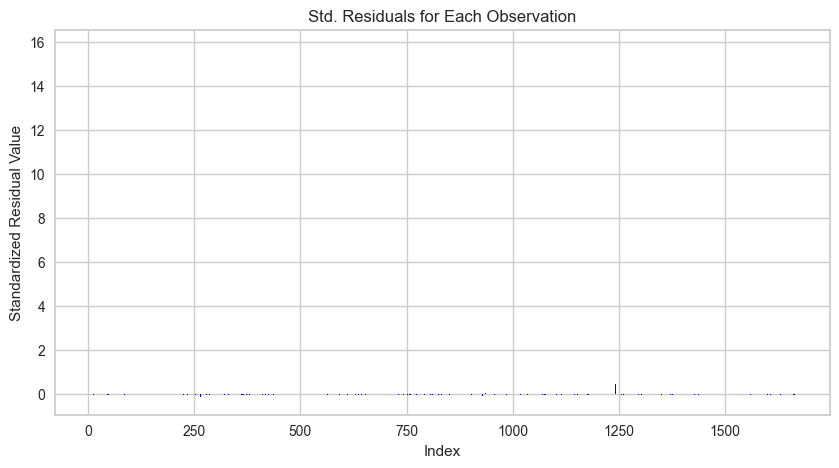

In [70]:
plt.figure(figsize=(10, 5))
plt.bar(outliers.index, outliers['standardized_residuals'], color='blue')
plt.xlabel('Index')
plt.ylabel('Standardized Residual Value')
plt.title('Std. Residuals for Each Observation')
plt.show()

#### Evaluating Outliers

Within the above interactive standardized residuals plot, three values are significant outliers and are labelled by index: r_###,r_###, and r_###. These residuals correspond to the index in my dataframe, however the index has been randomized during the data sampling process.

I've created a list of the 10 largest magnitude residuals in my dataset as a list called outliers_list.

Let's investigate these outliers.

The above outliers are all relatively short tunneling projects, which is a group of projects that I would expect to be difficult to model given the complexities and costs involved with tunneling.

In [73]:
outliers_df = df.loc[outliers_list]

In [74]:
outliers_df['cost_real_2023'].sort_values()

1644    2088945.639
Name: cost_real_2023, dtype: float64

By looking at the real cost (target feature) in our outliers list we can see that the largest residual also corresponds to the a real cost that is much higher than the rest of the values. Let's compare this outlier with the whole dataset to see if it's also an outlier.

In [75]:
def convert_str_to_float(val):
    if isinstance(val, str):
        return float(val.replace(',', ''))
    return val

df['cost_real_2023'] = df['cost_real_2023'].apply(convert_str_to_float)
df['cost'] = df['cost'].apply(convert_str_to_float)
df['track_gauge'] = df['track_gauge'].apply(convert_str_to_float)
df['union_density'] = df['union_density'].apply(convert_str_to_float)

In [76]:
df.sort_values(by = 'cost_real_2023',ascending = False).head(10)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
1644,BY,Minsk,2014,2023,0.0,17.20,1.000000,17.20,0.00,0.00,...,56.416667,2019,14,212,0,1,4,21,10.000000,0.406977
1131,AR,Buenos Aires,1990,1995,1.0,15.50,0.000000,0.00,0.00,15.50,...,102.916667,1993,9,1669,0,1,1,13,33.477516,0.709677
1626,VE,Valencia,1994,2006,0.0,4.30,1.000000,4.30,0.00,0.00,...,126.250000,2000,7,239,1,0,19,6,0.200000,1.162791
551,TW,Taipei,1988,2012,0.0,93.90,0.648562,60.90,33.00,0.00,...,197.500000,2000,13,81,1,1,1,69,39.355000,0.979766
1003,IR,Tehran,1995,1999,1.0,19.04,0.000000,0.00,0.00,19.04,...,19.166667,1997,4,22,0,1,7,12,0.000000,0.315126
1225,EG,Alexandria,2016,2023,1.0,280.00,0.000000,0.00,0.00,280.00,...,30.416667,2020,13,193,0,1,5,18,23.800000,0.057143
230,EG,Cairo,2007,2024,0.0,41.30,0.000000,0.00,0.00,41.30,...,19.680000,2016,10,131,0,1,7,14,23.800000,0.823245
1216,TW,Kaohsiung,2001,2008,0.0,43.00,0.739535,31.80,11.20,0.00,...,197.500000,2005,15,93,1,1,1,68,39.355000,0.883721
1242,QA,Doha,2013,2026,0.0,124.00,0.899194,111.50,6.00,6.50,...,9.166667,2020,5,45,2,1,7,13,0.000000,0.435484
345,KR,Seoul,1978,1982,0.0,50.20,0.800000,40.16,10.04,0.00,...,114.250000,1980,0,29,1,1,6,0,9.769591,1.015936


Notably, each of the outliers as shown in the residuals plot are also within the top 50 most expensive projects of the entire dataset. To correct this, I'll need to individually verify the values recorded for each project.

In [77]:
outliers_list

[1644]

### Interpreting Residuals v. Leverage Plot

The Residuals vs. Leverage plot provides insight into the influence of individual observations on the model's estimates. Points with high leverage have a large potential to influence the fit of the model, while points with high residuals do not fit the model well. 

Observations that are situated in the top right or bottom right corners of the plot—meaning they have both high leverage and high residuals—are particularly influential and may be of concern. They might indicate outliers, leverage points, or both and could potentially distort the model's predictions. Monitoring these points can help improve the model's robustness and accuracy.

In [78]:
plot_model(best, plot = 'residuals_interactive')

    'data': [{'hovertemplate': 'Split=train<br>Predictions…

In the bottom right corner, we have our residuals/leverage plot. This plot shows that several points outside of the cooks line.

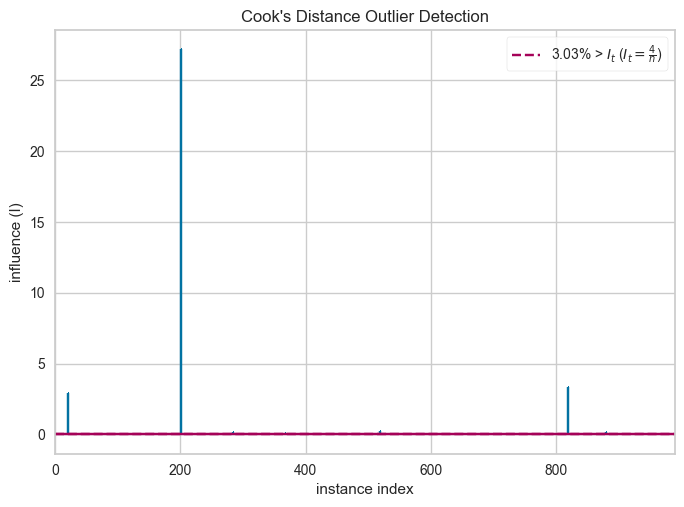

In [79]:
plot_model(best, plot='cooks')

Plotting the influence vs the cooks distance shows that the majority of the points are below the cooks line, but there are several outliers. Specifically the indexes that I discussed above. As we can see, there are approximately 6 points in the dataset that erroneously influence the dataset.

With the index on the x-axis, and using the other plots, we can estimate which indexes are causing this error. According to the scale-Location plot and the Tukey-Anscombe plot, indexes 296,611, and 776 appear to be responsible for some influence over the result. Since this result will vary after each model pass, I'd like to use other methods like IQR plots and z-scores to more comprehensively search for outliers.

### Z-Scores

Z-scores measure how many standard deviations a data point is from the mean of a dataset. They provide a standardized way to compare values from different datasets or units. A Z-score of zero indicates that the data point's score is identical to the mean score. Positive or negative Z-scores represent values above or below the mean, respectively. They are frequently used in statistics to identify outliers and understand data variability.

Within my dataset there are three types of data: continuous, categorical, and ordinal data. I'll be calculating the z-scores for only the continuous features (numbers).

In [80]:
pd.set_option('display.max_rows', None)

In [125]:
cont_feats = df.drop(columns=['country','city','region', 'sub_region','wrb_class_value','cost_real_2023','wrb_class_name','currency','train_type']).columns.tolist()

In [126]:
df[df['cost'].isna()]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km


In [127]:
continuous_data_array = df[cont_feats].to_numpy()

In [128]:
df['cost'] = pd.to_numeric(df['cost'])
df['track_gauge'] = pd.to_numeric(df['track_gauge'], errors='coerce')

In [131]:
monitored_features =['cost_km_2023','length']

In [132]:
z_scores = np.abs(zscore(continuous_data_array))
z_scores_monitored = np.abs(zscore(df[monitored_features]))

In [133]:
df_zscores_monitored = df[monitored_features].copy()
for i, column in enumerate(monitored_features):
    df_zscores_monitored[column + '_zscore'] = z_scores[:, i]

In [134]:
df_model_zscores = df_model.copy()
for i, column in enumerate(cont_feats):
    df_model_zscores[column + '_zscore'] = z_scores[:, i]

In [ ]:
df_model_zscores

In [136]:
threshold = 3
outliers = (z_scores_monitored > threshold)

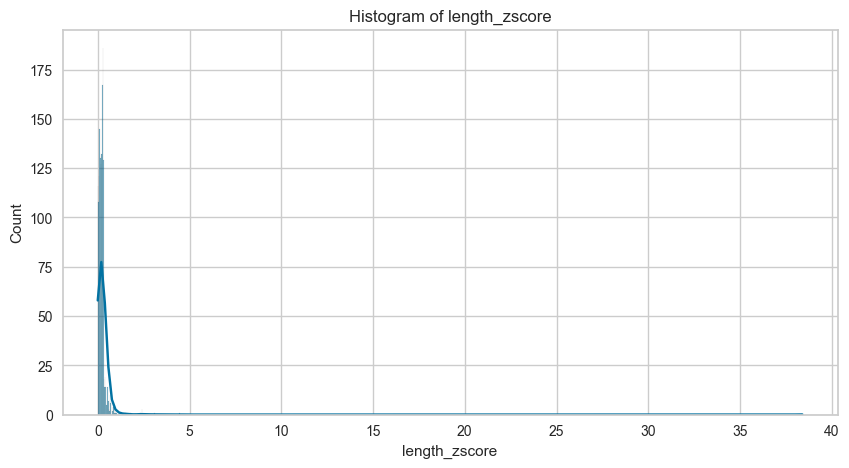

In [137]:
column_to_plot = "length_zscore"

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df_model_zscores[column_to_plot], kde=True)
plt.title(f'Histogram of {column_to_plot}')
plt.show()

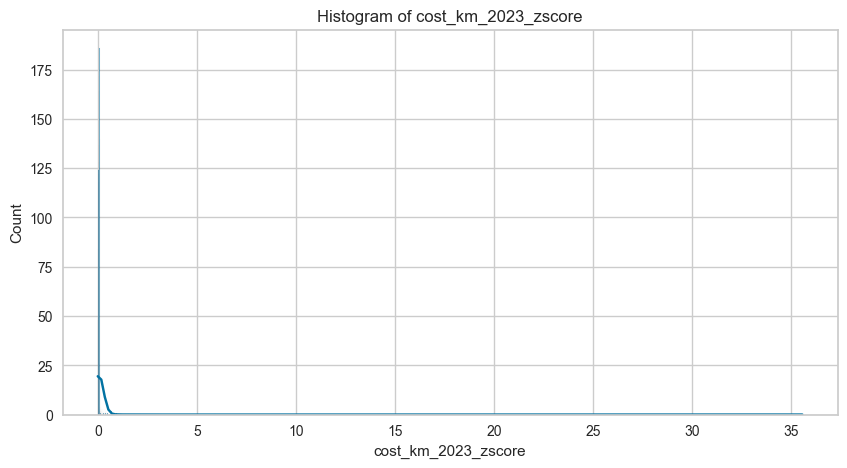

In [138]:
column_to_plot = "cost_km_2023_zscore"

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df_model_zscores[column_to_plot], kde=True)
plt.title(f'Histogram of {column_to_plot}')
plt.show()

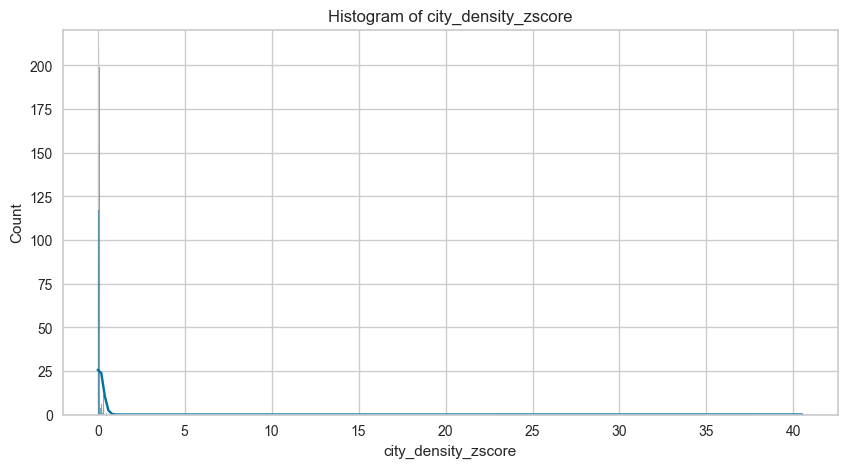

In [139]:
column_to_plot = "city_density_zscore" 

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df_model_zscores[column_to_plot], kde=True)
plt.title(f'Histogram of {column_to_plot}')
plt.show()

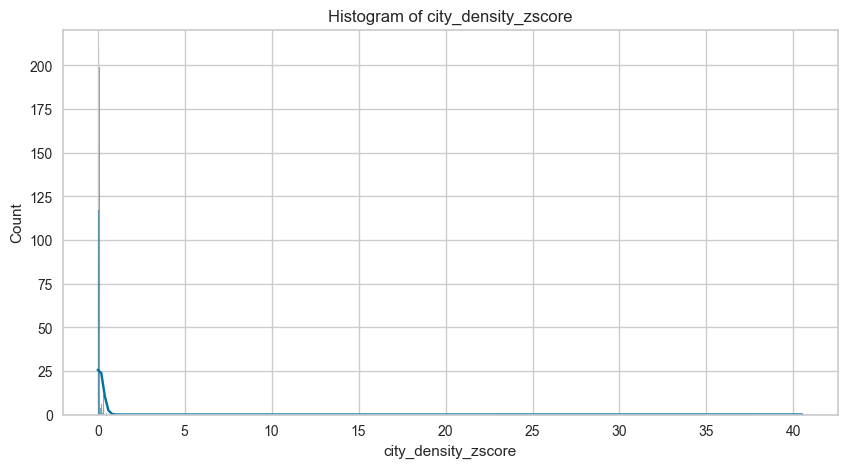

In [140]:
column_to_plot = "city_density_zscore"

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df_model_zscores[column_to_plot], kde=True)
plt.title(f'Histogram of {column_to_plot}')
plt.show()

### Analysis of Z-score Plots

There are several things, I'm looking for in the above z-score distributions:

- 1. The magnitude of the scores themselves

Within each of the above plots, we can see that the majority of the data is within 1 standard deviation of the mean (0). This is good, and healthy, but there is also a smaller minority that is beyond 3 standard deviations of the mean.
- 2. Spread of the scores

The spread refers to the shape of the distributions. Since we're dealing with features that are incapable of being negative, we can only really look at the right spread of the data. Again, the spread is generally within a standard deviation of the mean. There is a longer tail within some of the distribtions, which tells me there are some outliers that should be removed.

- 3. Shape of the scores

This is called Kurtosis, but just think of it as the flatness/peakyness. Each curve is relatively peaky in that they aren't flat. This is an indicator that there is a significant grouping around specific values. When these groups occur beyond 2 standard deviations, that's a signal that there are outliers.
    

### IQR Plots

In [141]:
Q1 = df[cont_feats].quantile(0.25)
Q3 = df[cont_feats].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = ((df[cont_feats] < lower_bound) | (df[cont_feats] > upper_bound))

#### Cost 2021

In [142]:
colors = np.where(outliers_iqr['cost_km_2023'], 'lightblue', 'pink')

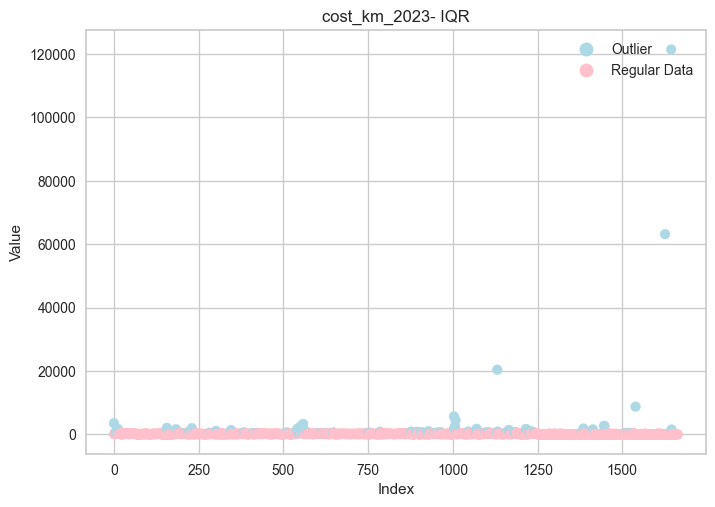

In [143]:
plt.scatter(df[cont_feats].index, df[cont_feats]['cost_km_2023'], c=colors)
plt.title("cost_km_2023- IQR")
plt.xlabel("Index")
plt.ylabel("Value")

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Outlier', markersize=10, markerfacecolor='lightblue'),
                   Line2D([0], [0], marker='o', color='w', label='Regular Data', markersize=10, markerfacecolor='pink')]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

In [144]:
outliers_iqr['cost_km_2023'].sum()

134

#### Length

In [145]:
colors = np.where(outliers_iqr['length'], 'lightblue', 'pink')

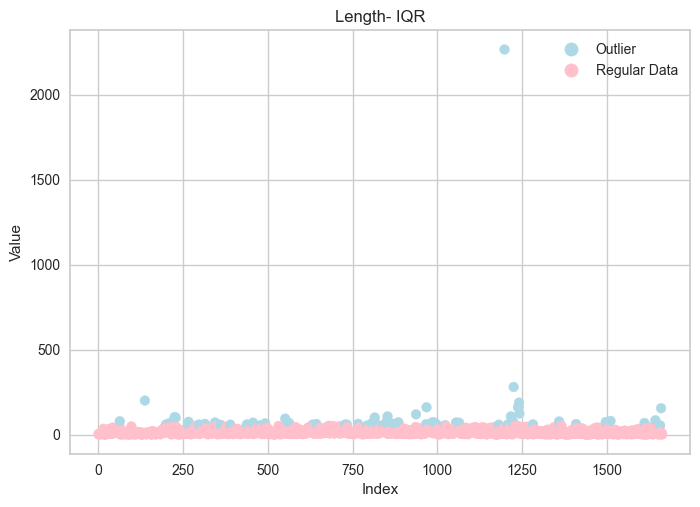

In [146]:
plt.scatter(df[cont_feats].index, df[cont_feats]['length'], c=colors)
plt.title("Length- IQR")
plt.xlabel("Index")
plt.ylabel("Value")

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Outlier', markersize=10, markerfacecolor='lightblue'),
                   Line2D([0], [0], marker='o', color='w', label='Regular Data', markersize=10, markerfacecolor='pink')]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

In [147]:
outliers_iqr['length'].sum()

74

#### City Density

In [148]:
colors = np.where(outliers_iqr['city_density'], 'lightblue', 'pink')

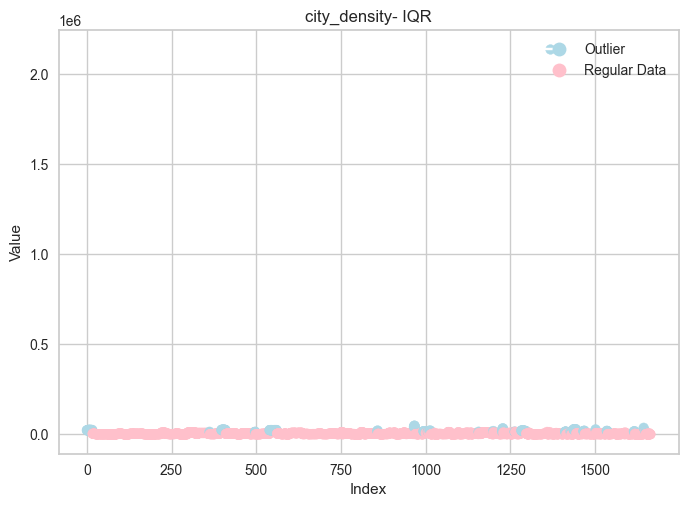

In [149]:
plt.scatter(df[cont_feats].index, df[cont_feats]['city_density'], c=colors)
plt.title("city_density- IQR")
plt.xlabel("Index")
plt.ylabel("Value")

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Outlier', markersize=10, markerfacecolor='lightblue'),
                   Line2D([0], [0], marker='o', color='w', label='Regular Data', markersize=10, markerfacecolor='pink')]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

In [150]:
outliers_iqr['city_density'].sum()

123

### Analysis of IQR plots

With the above plot, it's difficult to tell which indexes are present in both the Z-score and the IQR plots. However, it's clear there are some outliers that need to be dealt with. Importantly however, it's notable that the dataset appears to be healthy, despite several outliers.

Given the context of the data, outliers (and errors) should be expected. It's difficult to organize a dataset over a period of time that accurately captures the minute details of a transit project that is occuring over several years. Even more challenging is that the data being collected is often shared by different cultures who have different unwritten rules about data reporting and how that data is transmitted.

Because of this, I'll need to be more permissive when it comes to outliers.

### Outlier Removal

To identify which outliers need to be evaluated, I'll gather the indexes that were flagged by both the z-score calculation and the IQR calculation. By doing this, I'm being relatively conservative in my estimation of these outliers. Rather than removing values that show up in either analysis, I'd like to evaluate only the most eggregious outliers in the dataset.

Additionally, I'll only be removing the outliers that are present in the most important features ('length','tunnel','duration','cost_km').

In [151]:
outliers_iqr = ((df[monitored_features] < lower_bound) | (df[monitored_features] > upper_bound))

In [152]:
outliers_combined = outliers | outliers_iqr

In [153]:
outliers_combined['length'].sum()

74

In [154]:
outliers_combined['duration'].sum()

0.0

In [155]:
outliers_combined['cost_km_2023'].sum()

134

In [156]:
selected_columns = ['cost_km_2023']

In [157]:
outliers_combined[selected_columns].sum()

cost_km_2023    134
dtype: int64

In [158]:
outliers_indices = outliers_combined[selected_columns].any(axis=1)
outliers_list = outliers_indices[outliers_indices].index.tolist()

In [159]:
len(outliers_list)

134

### Target Variable Outliers

Since the method I used to evaluate the outliers in the non-target variables used the same processed data as the model, the target variable was dropped from the dataset and not included in the previous outlier evaluation.

In [160]:
Q1 = df['cost_real_2023'].quantile(0.25)
Q3 = df['cost_real_2023'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers_iqr_target = ((df['cost_real_2023'] < lower_bound) | (df['cost_real_2023'] > upper_bound))

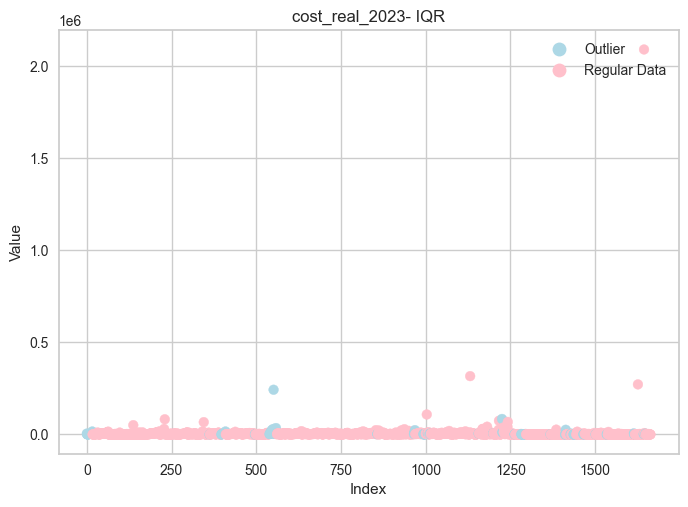

In [161]:
plt.scatter(df[cont_feats].index, df['cost_real_2023'], c=colors)
plt.title("cost_real_2023- IQR")
plt.xlabel("Index")
plt.ylabel("Value")

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Outlier', markersize=10, markerfacecolor='lightblue'),
                   Line2D([0], [0], marker='o', color='w', label='Regular Data', markersize=10, markerfacecolor='pink')]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

In [162]:
outliers_iqr_target = ((df['cost_real_2023'] < lower_bound) | (df['cost_real_2023'] > upper_bound))

In [163]:
outlier_indices = df[outliers_iqr_target].index.tolist()

In [164]:
len(outlier_indices)

95

In [165]:
outliers_list.extend(outlier_indices)

In [166]:
outliers_list = list(set(outliers_list))

In [167]:
len(outliers_list)

177

### Model Summary

In [168]:
data_summary = {
    'Model': [
        'Model First Pass'
    ],
    'Version': ['M_A1'],
    'Dataset': ['Base df'],
    'MAE': [2036.8804],
    'MSE': [32780828.8929],
    'RMSE': [5725.4545],
    'R2': [0.3923],
    'RMSLE': [0.8174],
    'MAPE': [0.7291]
}

combined_metrics = pd.DataFrame(data_summary)

In [169]:
combined_metrics

,Model,Version,Dataset,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Model First Pass,M_A1,Base df,2036.8804,3.278083e+07,5725.4545,0.3923,0.8174,0.7291


### Pickles

In [123]:
with open('pickles/outliers_list.pkl', 'wb') as f:
    pickle.dump(outliers_list, f)
with open('pickles/combined_metrics.pkl', 'wb') as f:
    pickle.dump(combined_metrics, f)

In [124]:
df.shape

(1664, 86)